## Data Collection

Main data collection is processed by running ['update.py'](https://github.com/cjunwon/Youtube-Data-Analysis/blob/main/update.py) on a Flask ['server.py'](https://github.com/cjunwon/Youtube-Data-Analysis/blob/main/server.py) scheduled through ngrok and Invictify.

This collection pipeline automatically updates the AWS MySQL RDS database with up-to-date channel statistics depending on the configured Invictify schedule.

In [6]:
from MySQL_DB_connect_functions import *
from MySQL_DB_update_functions import *
from youtube_api_functions import *

In [7]:
channel_id_list = ['UCIRYBXDze5krPDzAEOxFGVA'] #TheGuardian
channel_id_list = ['UCqnbDFdCpuN8CMEg0VuEBqA'] #NYTimes

In [8]:
# using youtube_api_functions.py:
youtube_obj = build_yt_API_object() # builds Youtube API object

In [9]:
video_df = create_video_df(youtube_obj, channel_id_list, 50) # store API data into pandas df
processed_video_df = clean_video_df(video_df) # run df through cleaning function

In [10]:
processed_video_df.head()

,video_id,channelTitle,title,description,publishedAt,viewCount,likeCount,favoriteCount,commentCount,caption,publishDayName,durationSecs,tagCount
0,FJvnn0qRWb4,The New York Times,Watch Warriors in Training in ‘The Woman King’...,The intensity of the action epic “The Woman Ki...,2022-09-16,2081,152,0,0,1,Friday,119.0,11
1,O5d1Cclk5QA,The New York Times,"I Sold the French Laundry. Then It Became ""The...","When my father died, he held disappointment in...",2022-09-13,47866,2170,0,218,1,Tuesday,1233.0,21
2,ccVH_1g-kCY,The New York Times,OB-GYNs Confront Legal Impact of Abortion Bans...,As anti-abortion laws take effect across the U...,2022-09-12,11569,603,0,318,1,Monday,379.0,33
3,0bw7rJ2eZaA,The New York Times,The Legacy of Elizabeth II: The Media Queen,"Queen Elizabeth II, the world’s longest-servin...",2022-09-08,55968,2049,0,377,1,Thursday,486.0,19
4,m5aWtcx02ZI,The New York Times,Jonathan Pie: Welcome to Britain. Everything i...,So Liz Truss will be Britain’s next prime mini...,2022-09-06,878372,44490,0,4993,1,Tuesday,401.0,15


In [11]:
video_ids = list(processed_video_df['video_id'])

In [12]:
video_ids

['FJvnn0qRWb4',
 'O5d1Cclk5QA',
 'ccVH_1g-kCY',
 '0bw7rJ2eZaA',
 'm5aWtcx02ZI',
 '3-MzNPcEh6M',
 'm0E_wMIwfSI',
 '4oyL1aESwSk',
 'X04HKyW-3hc',
 'eMGqvUZjkH8',
 'UlAOP8GIuIY',
 'pjn_MJx-mJ8',
 'yOy5BMItCuU',
 '-p0x_woeZD8',
 'RilwnjDwTOc',
 'IAWtx-rsXpo',
 'DHJtdX481is',
 'tjIgYs81mB8',
 'faL6ERtj5oM',
 'mX80JIl6vFs',
 'Oo_FM3mjBCY',
 '2D_Ogifqm2c',
 '-DfLbrUa5Ng',
 '9RnjVFZoHuc',
 '43nX7uzD-Lc',
 'iZhjGQlq9io',
 'y3LPHMl5cqw',
 'jji9hiaAMvc',
 'v1_ilS5zku8',
 'j4qwMGd2wmQ',
 'QJaCliumTcA',
 'pCCTf17ZiIs',
 'AhJiSZHHHHs',
 'UjmhDyJhgvs',
 'lzmyO0E5ClU',
 'CawT_sqiBxo',
 'tuGdOAY33MI',
 'Wr7BrKOX6bE',
 'Q8DrPYj-REc',
 'ODU_QasrkcQ',
 'N04aLpZ0SJ8',
 'pCnlxfBgq4o',
 'SJn1ZFEi3Mo',
 'ww8PjviNPfw',
 'gCldVMfFim8',
 'NkMsSXzRBEs',
 'Ws0mMP7uM34',
 'j-88-Fttz7w',
 'DGxE64cGbZQ',
 'gOmYi96cU1M']

In [13]:
all_comments_df = pd.DataFrame()
for video in video_ids:
    comment_data = get_video_comments(youtube_obj, video)
    all_comments_df = all_comments_df.append(comment_data, ignore_index=True)

In [14]:
all_comments_df.head()

,video_id,comment_id,comment,date
0,O5d1Cclk5QA,UgwN5U3S_bClNWg9mO14AaABAg,"Hi there! I'm Ben Proudfoot, the director and ...",2022-09-13T17:48:37Z
1,O5d1Cclk5QA,UgxoHKeoMxf7gX2S9o14AaABAg,What an incredible piece of food journalism! S...,2022-09-15T22:54:51Z
2,O5d1Cclk5QA,Ugx4m090jOxgY61GEAB4AaABAg,I’ve heard about the infamous French Laundry r...,2022-09-15T22:05:57Z
3,O5d1Cclk5QA,UgyK5ScVQYz2CljWQsp4AaABAg,This was inspiring and makes me feel nostalgic...,2022-09-15T21:38:59Z
4,O5d1Cclk5QA,UgxYrat_ikBHRnQQMVR4AaABAg,Just watched this. We were blown away by the t...,2022-09-15T18:52:47Z


In [15]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [16]:
all_comments_df['vader_sentiment'] = all_comments_df.comment.apply(lambda x: sia.polarity_scores(x))
all_comments_df['vader_comp_sentiment'] = all_comments_df.vader_sentiment.apply(lambda x: x['compound'])

In [17]:
all_comments_df['vader_comp_sentiment'].mean()

0.048862135454326674

In [18]:
video_comp_sentiments = pd.DataFrame(columns=['video_id', 'vid_title', 'avg_comp_sentiment', 'vid_viewcount'])
for video in video_ids:
    comment_data = get_video_comments(youtube_obj, video)
    comment_data['vader_sentiment'] = comment_data.comment.apply(lambda x: sia.polarity_scores(x))
    comment_data['vader_comp_sentiment'] = comment_data.vader_sentiment.apply(lambda x: x['compound'])
    comp_mean = comment_data['vader_comp_sentiment'].mean()

    vid_title = processed_video_df.loc[processed_video_df['video_id'] == video, 'title'].item()
    vid_viewcount = processed_video_df.loc[processed_video_df['video_id'] == video, 'viewCount'].item()
    vid_likecount = processed_video_df.loc[processed_video_df['video_id'] == video, 'likeCount'].item()

    dict = {'video_id': video,
            'vid_title': vid_title,
            'avg_comp_sentiment': comp_mean,
            'vid_viewcount': vid_viewcount,
            'vid_likecount': vid_likecount
            }

    video_comp_sentiments = video_comp_sentiments.append(dict, ignore_index=True)
    

In [19]:
video_comp_sentiments

,video_id,vid_title,avg_comp_sentiment,vid_viewcount,vid_likecount
0,FJvnn0qRWb4,Watch Warriors in Training in ‘The Woman King’...,NaN,2081,152.0
1,O5d1Cclk5QA,"I Sold the French Laundry. Then It Became ""The...",0.539888,47866,2170.0
2,ccVH_1g-kCY,OB-GYNs Confront Legal Impact of Abortion Bans...,-0.154864,11569,603.0
3,0bw7rJ2eZaA,The Legacy of Elizabeth II: The Media Queen,0.077100,55968,2049.0
4,m5aWtcx02ZI,Jonathan Pie: Welcome to Britain. Everything i...,0.040505,878372,44490.0
5,3-MzNPcEh6M,I Have Face Blindness. This Is How I Recognize...,0.349753,19655,736.0
6,m0E_wMIwfSI,I Stutter. But I Need You to Listen. | NYT Opi...,0.248334,36553,2138.0
7,4oyL1aESwSk,Watch a Tense Pool Scene From ‘Bodies Bodies B...,0.214835,31856,407.0
8,X04HKyW-3hc,What a Legally Blind Person Can See | NYT Opinion,0.351140,23455,1149.0
9,eMGqvUZjkH8,Kill Your Lawn | NYT Opinion,0.118600,85999,3603.0


In [20]:
import plotly.io as pio

pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'vscode'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

In [21]:
pip install orca

Note: you may need to restart the kernel to use updated packages.


In [22]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [23]:
pip install -U kaleido

Note: you may need to restart the kernel to use updated packages.


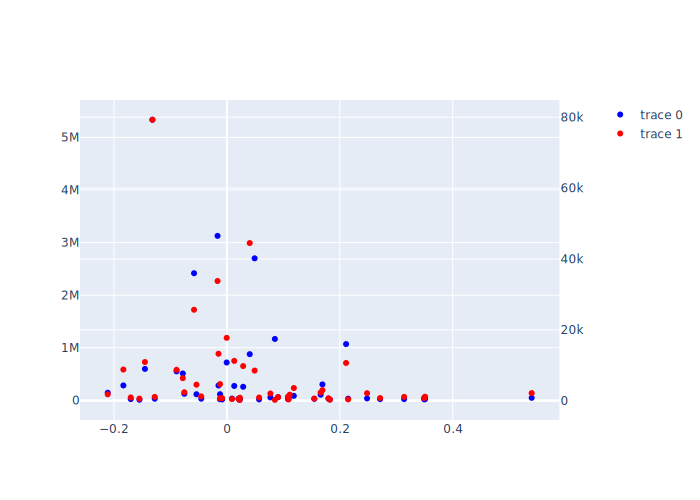

In [24]:
fig = make_subplots(specs=[[{'secondary_y': True}]])

fig.add_trace(
        go.Scatter(
        x=video_comp_sentiments['avg_comp_sentiment'],
        y=video_comp_sentiments['vid_viewcount'],
        mode='markers',
        marker_color='Blue',
        text=video_comp_sentiments['vid_title'],
        hovertemplate='<b>%{text}</b> <br>Sentiment Value: %{x} <br>View Count: %{y}'),
        secondary_y=False
)

fig.add_trace(go.Scatter(
    x=video_comp_sentiments['avg_comp_sentiment'],
    y=video_comp_sentiments['vid_likecount'],
    mode='markers',
    marker_color='Red',
    text=video_comp_sentiments['vid_title'],
    hovertemplate='<b>%{text}</b> <br>Sentiment Value: %{x} <br>Like Count: %{y}'),
    secondary_y=True
)

fig.show(renderer='svg')

In [25]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
 
# plot a scatter chart by specifying the x and y values
# Use add_trace function to specify secondary_y axes.
fig.add_trace(
    go.Scatter(x=[10, 20, 30], y=[400, 500, 600], name="yaxis values"),
    secondary_y=False)
 
# Use add_trace function and specify secondary_y axes = True.
fig.add_trace(
    go.Scatter(x=[20, 30, 40], y=[40, 50, 60], name="yaxis2 values"),
    secondary_y=True,)
 
# Adding title text to the figure
fig.update_layout(
    title_text="Multiple Y Axis in Plotly"
)
 
# Naming x-axis
fig.update_xaxes(title_text="X - axis")
 
# Naming y-axes
fig.update_yaxes(title_text="<b>Main</b> Y - axis ", secondary_y=False)
fig.update_yaxes(title_text="<b>secondary</b> Y - axis ", secondary_y=True)